In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.ndimage import rotate
import numpy as np
import random
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import segmentation_models_pytorch as smp
from pytorch_msssim import ssim
from skimage.metrics import structural_similarity as ev_ssim
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import logging

### Saving the dataset as an .npz file, this way it is easier to transfer it 

In [ ]:
lr_folder = 'Dataset 3B/dataset/LR'
hr_folder = 'Dataset 3B/dataset/HR'

# Helper to extract sample number from filename like 'sample32.npy'
def extract_index(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

lr_files = {extract_index(f): os.path.join(lr_folder, f) for f in os.listdir(lr_folder) if f.endswith('.npy')}
hr_files = {extract_index(f): os.path.join(hr_folder, f) for f in os.listdir(hr_folder) if f.endswith('.npy')}

common_indices = sorted(set(lr_files.keys()) & set(hr_files.keys()))

if not common_indices:
    raise ValueError("No matching samples found between LR and HR folders.")

lr_images = []
hr_images = []

for idx in tqdm(common_indices):
    lr_img = np.load(lr_files[idx])
    hr_img = np.load(hr_files[idx])
    lr_images.append(lr_img)
    hr_images.append(hr_img)

lr_dataset = np.stack(lr_images)
hr_dataset = np.stack(hr_images)

np.savez('3B_lr_hr_dataset.npz', lr=lr_dataset, hr=hr_dataset)

### Load the dataset and check images in 
In the previous example interpolation worked pretty well, so this time again the low resolution images are directly interpolated to match the size of the output high resolution label

In [2]:
class SuperResDataset(Dataset):
    def __init__(self, lr, hr):
        self.lr = torch.tensor(lr, dtype=torch.float32)
        self.hr = torch.tensor(hr, dtype=torch.float32)

    def __len__(self):
        return len(self.lr)

    def __getitem__(self, idx):
        lr = self.lr[idx]  
        hr = self.hr[idx]  
        
        lr_up = F.interpolate(lr.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)
        
        return lr_up, hr


def show_dataset_grid(dataset, samples_per_row=1, num_rows=4, start=0):
    total = samples_per_row * num_rows
    end = min(start + total, len(dataset))
    
    fig, axes = plt.subplots(num_rows, samples_per_row * 2, figsize=(samples_per_row * 7, num_rows*5 ))

    for i, idx in enumerate(range(start, end)):
        lr, hr = dataset[idx]
        lr = lr.squeeze().numpy()
        hr = hr.squeeze().numpy()

        row = i // samples_per_row
        col = (i % samples_per_row) * 2

        # LR image
        axes[row, col].imshow(lr, cmap='gray')
        axes[row, col].set_title(f"LR [{idx}]")
        axes[row, col].axis('off')

        # HR image
        axes[row, col + 1].imshow(hr, cmap='gray')
        axes[row, col + 1].set_title(f"HR [{idx}]")
        axes[row, col + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
data = np.load('3B_lr_hr_dataset.npz')
lr_data = data['lr']  
hr_data = data['hr']  

original_dataset = SuperResDataset(lr_data, hr_data)

In [4]:
# show_dataset_grid(original_dataset, start = 270, samples_per_row=1, num_rows=30)

### I manually exclude couple of clearly corrupt images, since dataset is small it might be important

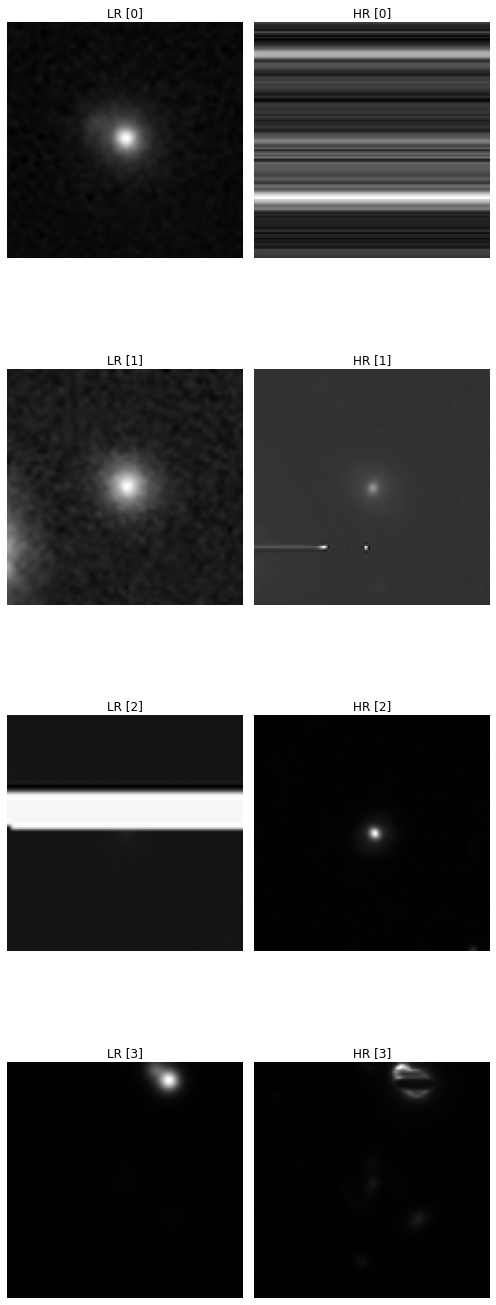

In [5]:
bad_indices = [11,32,191,208]
bad_dataset = Subset(original_dataset, bad_indices)
bad_loader = DataLoader(bad_dataset, batch_size=1, shuffle=False)

good_indices = [i for i in range(len(original_dataset)) if i not in bad_indices]
clean_dataset = torch.utils.data.Subset(original_dataset, good_indices)

show_dataset_grid(bad_dataset)

### Now since the dataset is small it requires augmentation
- First I added rotations by 90, 180 and 270 degrees and reflections along horizontal and vertical axes. However, the training was still a bit unstable.
- Second I created a new dataset, each element of which is a random sum of multiple images (2 to 4) of the previous dataset and again normalized between 0 and 1. So I created a set of 7000 such images and add to the previous dataset.

In [6]:
# Start with separating the test set

train_size = int(0.9 * len(clean_dataset))
test_size = len(clean_dataset) - train_size
train_base, test_set = random_split(clean_dataset, [train_size, test_size])

In [7]:
augmented_lr = []
augmented_hr = []

for lr, hr in [train_base[i] for i in range(len(train_base))]:
    for k in range(4):  # Rotations: 0°, 90°, 180°, 270°
        lr_rot = np.rot90(lr.numpy(), k, axes=(-2, -1))
        hr_rot = np.rot90(hr.numpy(), k, axes=(-2, -1))

        for flip_h in [False, True]:  # Horizontal flip
            lr_hflip = np.flip(lr_rot, axis=-1) if flip_h else lr_rot
            hr_hflip = np.flip(hr_rot, axis=-1) if flip_h else hr_rot

            for flip_v in [False, True]:  # Vertical flip
                lr_aug = np.flip(lr_hflip, axis=-2) if flip_v else lr_hflip
                hr_aug = np.flip(hr_hflip, axis=-2) if flip_v else hr_hflip

                augmented_lr.append(lr_aug.copy())
                augmented_hr.append(hr_aug.copy())

augmented_lr = np.stack(augmented_lr)
augmented_hr = np.stack(augmented_hr)

train_original_lr = np.stack([train_base[i][0].numpy() for i in range(len(train_base))])
train_original_hr = np.stack([train_base[i][1].numpy() for i in range(len(train_base))])

rot_train_lr = np.concatenate([train_original_lr, augmented_lr])
rot_train_hr = np.concatenate([train_original_hr, augmented_hr])

###  Further augmenting
- Second I created a new dataset, each element of which is a random sum of multiple images (2 to 4) of the previous dataset and again normalized between 0 and 1. So I created a set of 7000 such images and add to the previous dataset. Potentially that can cause problems in case different images are lensed differently, but I didn't notice any perfomance decrease due to this

In [8]:
def generate_multi_mix_samples(lr_data, hr_data, count=1000, max_images=4):
    n = len(lr_data)
    new_lr = []
    new_hr = []

    for _ in range(count):
        k = np.random.randint(2, max_images + 1)  # Randomly pick 2 to `max_images`
        indices = np.random.choice(n, k, replace=False)
        
        weights = np.random.dirichlet(np.ones(k))
        lr_mix = sum(w * lr_data[i] for w, i in zip(weights, indices))
        hr_mix = sum(w * hr_data[i] for w, i in zip(weights, indices))

        # Normalize to [0, 1]
        lr_mix = (lr_mix - lr_mix.min()) / max(1e-8, lr_mix.max() - lr_mix.min())
        hr_mix = (hr_mix - hr_mix.min()) / max(1e-8, hr_mix.max() - hr_mix.min())

        new_lr.append(lr_mix)
        new_hr.append(hr_mix)

    return np.stack(new_lr), np.stack(new_hr)

In [9]:
mixed_sum_lr, mixed_sum_hr = generate_multi_mix_samples(rot_train_lr, rot_train_hr, count=7000)

full_train_lr = np.concatenate([rot_train_lr, mixed_sum_lr])
full_train_hr = np.concatenate([rot_train_hr, mixed_sum_hr])

train_set = SuperResDataset(full_train_lr, full_train_hr)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16)

### Some useful functions
- Model evaluation and result plotting functions
- Logging
- Further loss functions

In [10]:
def evaluate_on_test_set(model, test_loader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0

    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            preds = model(lr_imgs) + lr_imgs

            loss = criterion(preds, hr_imgs)
            total_loss += loss.item()

            preds_np = preds.cpu().numpy()
            hr_np = hr_imgs.cpu().numpy()

            for pred, gt in zip(preds_np, hr_np):
                pred_img = np.squeeze(pred)
                gt_img = np.squeeze(gt)

                total_psnr += psnr(gt_img, pred_img, data_range=1.0)
                total_ssim += ev_ssim(gt_img, pred_img, data_range=1.0)
                count += 1

    avg_loss = total_loss / len(test_loader)
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count

    return avg_loss, avg_psnr, avg_ssim

def plot_super_resolution_sample(model, dataset, index=0, device='cuda'):
    model.eval()
    
    # Get one sample
    lr_img, hr_img = dataset[index]
    lr_img = lr_img.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        pred = model(lr_img)

    # Move tensors to CPU and squeeze
    
    lr_img = F.interpolate(lr_img, size=(128, 128), mode='bilinear', align_corners=False)
    lr_img = lr_img.squeeze().cpu().numpy()
    pred_img = pred.squeeze().cpu().numpy() +lr_img
    hr_img = hr_img.squeeze().cpu().numpy()

    ssim_score = ev_ssim(hr_img, pred_img, data_range=1.0)
    psnr_score = psnr(hr_img, pred_img, data_range=1.0)
    mse_score = np.mean((pred_img - hr_img) ** 2)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(lr_img, cmap='gray')
    axes[0].set_title('Interpolated LR Input')
    
    axes[1].imshow(pred_img, cmap='gray')

    axes[1].set_title(f'Predicted HR\nSSIM: {ssim_score:.4f}\nPSNR: {psnr_score:.2f} dB\nMSE: {mse_score:.5f}')


    axes[2].imshow(hr_img, cmap='gray')
    axes[2].set_title('True HR')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def create_run_dir(base_dir='runs'):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(base_dir, f"run_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)
    return run_dir

def setup_logger(run_dir, log_name='training.log'):
    log_path = os.path.join(run_dir, log_name)
    logging.basicConfig(
        filename=log_path,
        filemode='a',
        format='%(asctime)s - %(message)s',
        level=logging.INFO
    )
    
    def log_and_print(msg):
        print(msg)
        logging.info(msg)
    
    return log_and_print

#######################################other losses
def ssim_loss(pred, target):
    return 1 - ssim(pred, target, data_range=1.0)

class CombinedLoss_L1_ssim(nn.Module):
    def __init__(self, alpha=0.8, beta=0.2):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, target):
        l1 = self.l1(pred, target)
        ssim_val = ssim_loss(pred, target)  
        return self.alpha * l1 + self.beta * ssim_val

##########################################################
def log_and_export_metrics(train_losses, test_losses, test_psnrs, test_ssims, run_dir):

    csv_path = os.path.join(run_dir, 'metrics.csv')

    # Plotting
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    # ---- Loss (Log Scale) ----
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    # ---- PSNR ----
    plt.subplot(1, 3, 2)
    plt.plot(epochs, test_psnrs, label='Test PSNR', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Test PSNR Over Epochs')
    plt.grid(True)

    # ---- SSIM ----
    plt.subplot(1, 3, 3)
    plt.plot(epochs, test_ssims, label='Test SSIM', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.title('Test SSIM Over Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(run_dir, 'metrics_plot.png'))
    plt.close()

    # Save CSV
    import pandas as pd
    df = pd.DataFrame({
        'epoch': epochs,
        'train_loss': train_losses,
        'test_loss': test_losses,
        'psnr': test_psnrs,
        'ssim': test_ssims
    })
    df.to_csv(csv_path, index=False)
    log_and_print(f"Metrics saved to: {csv_path}")

### Initializing the model for training
To deal with the limited dataset following steps were implemented:
- A U-Net with a pretrained ResNet18 as an encoder
- Output of the network is summed with the input, so the network reconstructs only the residual - the difference between the original lr image and the hr label
- Weight decay to reduce overfitting
- Scheduler to adjust the learning rate during training

In [11]:
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).cuda()

In [12]:
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',    
    factor=0.5,          
    patience=5,              
    min_lr=1e-8 
)

### Training the model 
Multiple types of loss functions and hyper parameters were tried, these seem to work the best

Starting new training run...
Run directory: runs/run_20250401_100007


Epoch 1/100: 100%|██████████| 361/361 [00:11<00:00, 32.06it/s]


Epoch 1: Train Loss = 0.04487468 | Test Loss = 0.00324070 | PSNR = 26.72 | SSIM = 0.4879
Learning rate: 1.0e-04


Epoch 2/100: 100%|██████████| 361/361 [00:11<00:00, 32.59it/s]


Epoch 2: Train Loss = 0.00240323 | Test Loss = 0.00217341 | PSNR = 28.29 | SSIM = 0.5686
Learning rate: 1.0e-04


Epoch 3/100: 100%|██████████| 361/361 [00:11<00:00, 32.35it/s]


Epoch 3: Train Loss = 0.00165346 | Test Loss = 0.00113643 | PSNR = 30.48 | SSIM = 0.6529
Learning rate: 1.0e-04


Epoch 4/100: 100%|██████████| 361/361 [00:11<00:00, 32.15it/s]


Epoch 4: Train Loss = 0.00133368 | Test Loss = 0.00123891 | PSNR = 30.00 | SSIM = 0.6182
Learning rate: 1.0e-04


Epoch 5/100: 100%|██████████| 361/361 [00:11<00:00, 31.98it/s]


Epoch 5: Train Loss = 0.00116304 | Test Loss = 0.00086614 | PSNR = 32.16 | SSIM = 0.7721
Learning rate: 1.0e-04


Epoch 6/100: 100%|██████████| 361/361 [00:11<00:00, 31.91it/s]


Epoch 6: Train Loss = 0.00103071 | Test Loss = 0.00084605 | PSNR = 32.01 | SSIM = 0.7440
Learning rate: 1.0e-04


Epoch 7/100: 100%|██████████| 361/361 [00:11<00:00, 31.80it/s]


Epoch 7: Train Loss = 0.00095220 | Test Loss = 0.00213304 | PSNR = 31.29 | SSIM = 0.7187
Learning rate: 1.0e-04


Epoch 8/100: 100%|██████████| 361/361 [00:11<00:00, 31.74it/s]


Epoch 8: Train Loss = 0.00093044 | Test Loss = 0.00064442 | PSNR = 33.71 | SSIM = 0.8251
Learning rate: 1.0e-04


Epoch 9/100: 100%|██████████| 361/361 [00:11<00:00, 31.68it/s]


Epoch 9: Train Loss = 0.00091506 | Test Loss = 0.00122399 | PSNR = 30.53 | SSIM = 0.6422
Learning rate: 1.0e-04


Epoch 10/100: 100%|██████████| 361/361 [00:11<00:00, 31.65it/s]


Epoch 10: Train Loss = 0.00093665 | Test Loss = 0.00069709 | PSNR = 32.27 | SSIM = 0.7516
Learning rate: 1.0e-04


Epoch 11/100: 100%|██████████| 361/361 [00:11<00:00, 31.64it/s]


Epoch 11: Train Loss = 0.00090022 | Test Loss = 0.00049065 | PSNR = 34.02 | SSIM = 0.8461
Learning rate: 1.0e-04


Epoch 12/100: 100%|██████████| 361/361 [00:11<00:00, 31.59it/s]


Epoch 12: Train Loss = 0.00084540 | Test Loss = 0.00050483 | PSNR = 34.13 | SSIM = 0.8394
Learning rate: 1.0e-04


Epoch 13/100: 100%|██████████| 361/361 [00:11<00:00, 31.62it/s]


Epoch 13: Train Loss = 0.00083378 | Test Loss = 0.00046216 | PSNR = 34.02 | SSIM = 0.8332
Learning rate: 1.0e-04


Epoch 14/100: 100%|██████████| 361/361 [00:11<00:00, 31.63it/s]


Epoch 14: Train Loss = 0.00083230 | Test Loss = 0.00094281 | PSNR = 33.58 | SSIM = 0.8373
Learning rate: 1.0e-04


Epoch 15/100: 100%|██████████| 361/361 [00:11<00:00, 31.60it/s]


Epoch 15: Train Loss = 0.00083469 | Test Loss = 0.00048312 | PSNR = 34.12 | SSIM = 0.8349
Learning rate: 1.0e-04


Epoch 16/100: 100%|██████████| 361/361 [00:11<00:00, 31.60it/s]


Epoch 16: Train Loss = 0.00081803 | Test Loss = 0.50484546 | PSNR = 7.54 | SSIM = 0.4363
Learning rate: 1.0e-04


Epoch 17/100: 100%|██████████| 361/361 [00:11<00:00, 31.58it/s]


Epoch 17: Train Loss = 0.00091125 | Test Loss = 0.00054065 | PSNR = 33.32 | SSIM = 0.7923
Learning rate: 1.0e-04


Epoch 18/100: 100%|██████████| 361/361 [00:11<00:00, 31.56it/s]


Epoch 18: Train Loss = 0.00081569 | Test Loss = 0.00060677 | PSNR = 33.96 | SSIM = 0.8467
Learning rate: 1.0e-04


Epoch 19/100: 100%|██████████| 361/361 [00:11<00:00, 31.55it/s]


Epoch 19: Train Loss = 0.00079322 | Test Loss = 0.00042027 | PSNR = 34.60 | SSIM = 0.8689
Learning rate: 1.0e-04


Epoch 20/100: 100%|██████████| 361/361 [00:11<00:00, 31.52it/s]


Epoch 20: Train Loss = 0.00078819 | Test Loss = 0.00063086 | PSNR = 34.21 | SSIM = 0.8514
Learning rate: 1.0e-04


Epoch 21/100: 100%|██████████| 361/361 [00:11<00:00, 31.55it/s]


Epoch 21: Train Loss = 0.00077210 | Test Loss = 0.00057101 | PSNR = 33.88 | SSIM = 0.8399
Learning rate: 1.0e-04


Epoch 22/100: 100%|██████████| 361/361 [00:11<00:00, 31.60it/s]


Epoch 22: Train Loss = 0.00090269 | Test Loss = 0.00053565 | PSNR = 33.91 | SSIM = 0.8265
Learning rate: 1.0e-04


Epoch 23/100: 100%|██████████| 361/361 [00:11<00:00, 31.62it/s]


Epoch 23: Train Loss = 0.00079101 | Test Loss = 0.00054214 | PSNR = 34.28 | SSIM = 0.8359
Learning rate: 1.0e-04


Epoch 24/100: 100%|██████████| 361/361 [00:11<00:00, 31.66it/s]


Epoch 24: Train Loss = 0.00074557 | Test Loss = 0.00645322 | PSNR = 30.14 | SSIM = 0.7689
Learning rate: 1.0e-04


Epoch 25/100: 100%|██████████| 361/361 [00:11<00:00, 31.68it/s]


Epoch 25: Train Loss = 0.00077265 | Test Loss = 0.00055628 | PSNR = 33.75 | SSIM = 0.8141
Learning rate: 5.0e-05


Epoch 26/100: 100%|██████████| 361/361 [00:11<00:00, 31.71it/s]


Epoch 26: Train Loss = 0.00070596 | Test Loss = 0.00042652 | PSNR = 34.72 | SSIM = 0.8660
Learning rate: 5.0e-05


Epoch 27/100: 100%|██████████| 361/361 [00:11<00:00, 31.74it/s]


Epoch 27: Train Loss = 0.00072255 | Test Loss = 0.00044593 | PSNR = 34.29 | SSIM = 0.8326
Learning rate: 5.0e-05


Epoch 28/100: 100%|██████████| 361/361 [00:11<00:00, 31.76it/s]


Epoch 28: Train Loss = 0.00069910 | Test Loss = 0.00050014 | PSNR = 34.43 | SSIM = 0.8365
Learning rate: 5.0e-05


Epoch 29/100: 100%|██████████| 361/361 [00:11<00:00, 31.78it/s]


Epoch 29: Train Loss = 0.00069318 | Test Loss = 0.00055161 | PSNR = 33.52 | SSIM = 0.7967
Learning rate: 5.0e-05


Epoch 30/100: 100%|██████████| 361/361 [00:11<00:00, 31.80it/s]


Epoch 30: Train Loss = 0.00069159 | Test Loss = 0.00046146 | PSNR = 34.49 | SSIM = 0.8649
Learning rate: 5.0e-05


Epoch 31/100: 100%|██████████| 361/361 [00:11<00:00, 31.81it/s]


Epoch 31: Train Loss = 0.00068254 | Test Loss = 0.00043300 | PSNR = 34.67 | SSIM = 0.8579
Learning rate: 2.5e-05


Epoch 32/100: 100%|██████████| 361/361 [00:11<00:00, 31.81it/s]


Epoch 32: Train Loss = 0.00066641 | Test Loss = 0.00043049 | PSNR = 34.53 | SSIM = 0.8746
Learning rate: 2.5e-05


Epoch 33/100: 100%|██████████| 361/361 [00:11<00:00, 31.82it/s]


Epoch 33: Train Loss = 0.00066618 | Test Loss = 0.00047111 | PSNR = 34.52 | SSIM = 0.8393
Learning rate: 2.5e-05


Epoch 34/100: 100%|██████████| 361/361 [00:11<00:00, 31.83it/s]


Epoch 34: Train Loss = 0.00066321 | Test Loss = 0.00047382 | PSNR = 34.19 | SSIM = 0.8402
Learning rate: 2.5e-05


Epoch 35/100: 100%|██████████| 361/361 [00:11<00:00, 31.85it/s]


Epoch 35: Train Loss = 0.00065921 | Test Loss = 0.00051540 | PSNR = 33.62 | SSIM = 0.8045
Learning rate: 2.5e-05


Epoch 36/100: 100%|██████████| 361/361 [00:11<00:00, 31.84it/s]


Epoch 36: Train Loss = 0.00065478 | Test Loss = 0.00040952 | PSNR = 34.97 | SSIM = 0.8788
Learning rate: 2.5e-05


Epoch 37/100: 100%|██████████| 361/361 [00:11<00:00, 31.81it/s]


Epoch 37: Train Loss = 0.00065762 | Test Loss = 0.00054818 | PSNR = 33.57 | SSIM = 0.8149
Learning rate: 2.5e-05


Epoch 38/100: 100%|██████████| 361/361 [00:11<00:00, 31.87it/s]


Epoch 38: Train Loss = 0.00065692 | Test Loss = 0.00054249 | PSNR = 33.67 | SSIM = 0.7967
Learning rate: 2.5e-05


Epoch 39/100: 100%|██████████| 361/361 [00:11<00:00, 31.87it/s]


Epoch 39: Train Loss = 0.00065844 | Test Loss = 0.00044469 | PSNR = 34.38 | SSIM = 0.8594
Learning rate: 2.5e-05


Epoch 40/100: 100%|██████████| 361/361 [00:11<00:00, 31.85it/s]


Epoch 40: Train Loss = 0.00065158 | Test Loss = 0.00048801 | PSNR = 34.11 | SSIM = 0.8174
Learning rate: 2.5e-05


Epoch 41/100: 100%|██████████| 361/361 [00:11<00:00, 31.91it/s]


Epoch 41: Train Loss = 0.00064267 | Test Loss = 0.00043857 | PSNR = 34.71 | SSIM = 0.8690
Learning rate: 2.5e-05


Epoch 42/100: 100%|██████████| 361/361 [00:11<00:00, 31.92it/s]


Epoch 42: Train Loss = 0.00065538 | Test Loss = 0.00042467 | PSNR = 34.55 | SSIM = 0.8495
Learning rate: 1.3e-05


Epoch 43/100: 100%|██████████| 361/361 [00:11<00:00, 31.97it/s]


Epoch 43: Train Loss = 0.00064383 | Test Loss = 0.00047297 | PSNR = 34.12 | SSIM = 0.7944
Learning rate: 1.3e-05


Epoch 44/100: 100%|██████████| 361/361 [00:11<00:00, 31.97it/s]


Epoch 44: Train Loss = 0.00063673 | Test Loss = 0.00049492 | PSNR = 34.08 | SSIM = 0.8162
Learning rate: 1.3e-05


Epoch 45/100: 100%|██████████| 361/361 [00:11<00:00, 31.96it/s]


Epoch 45: Train Loss = 0.00063212 | Test Loss = 0.00038378 | PSNR = 35.30 | SSIM = 0.8825
Learning rate: 1.3e-05


Epoch 46/100: 100%|██████████| 361/361 [00:11<00:00, 31.98it/s]


Epoch 46: Train Loss = 0.00062938 | Test Loss = 0.00040555 | PSNR = 35.09 | SSIM = 0.8714
Learning rate: 1.3e-05


Epoch 47/100: 100%|██████████| 361/361 [00:11<00:00, 31.98it/s]


Epoch 47: Train Loss = 0.00062797 | Test Loss = 0.00042396 | PSNR = 34.89 | SSIM = 0.8705
Learning rate: 1.3e-05


Epoch 48/100: 100%|██████████| 361/361 [00:11<00:00, 32.02it/s]


Epoch 48: Train Loss = 0.00062756 | Test Loss = 0.00038603 | PSNR = 35.07 | SSIM = 0.8590
Learning rate: 1.3e-05


Epoch 49/100: 100%|██████████| 361/361 [00:11<00:00, 32.05it/s]


Epoch 49: Train Loss = 0.00062956 | Test Loss = 0.00048940 | PSNR = 34.14 | SSIM = 0.8419
Learning rate: 1.3e-05


Epoch 50/100: 100%|██████████| 361/361 [00:11<00:00, 32.06it/s]


Epoch 50: Train Loss = 0.00063163 | Test Loss = 0.00039384 | PSNR = 35.26 | SSIM = 0.8764
Saved model at epoch 50 to runs/run_20250401_100007/model_epoch_50.pth
Learning rate: 1.3e-05


Epoch 51/100: 100%|██████████| 361/361 [00:11<00:00, 32.09it/s]


Epoch 51: Train Loss = 0.00062855 | Test Loss = 0.00052647 | PSNR = 33.66 | SSIM = 0.7720
Learning rate: 6.3e-06


Epoch 52/100: 100%|██████████| 361/361 [00:11<00:00, 32.09it/s]


Epoch 52: Train Loss = 0.00061654 | Test Loss = 0.00041944 | PSNR = 34.94 | SSIM = 0.8860
Learning rate: 6.3e-06


Epoch 53/100: 100%|██████████| 361/361 [00:11<00:00, 32.11it/s]


Epoch 53: Train Loss = 0.00061534 | Test Loss = 0.00043123 | PSNR = 34.93 | SSIM = 0.8677
Learning rate: 6.3e-06


Epoch 54/100: 100%|██████████| 361/361 [00:11<00:00, 32.12it/s]


Epoch 54: Train Loss = 0.00061345 | Test Loss = 0.00041745 | PSNR = 34.83 | SSIM = 0.8667
Learning rate: 6.3e-06


Epoch 55/100: 100%|██████████| 361/361 [00:11<00:00, 32.13it/s]


Epoch 55: Train Loss = 0.00061894 | Test Loss = 0.00039061 | PSNR = 35.22 | SSIM = 0.8887
Learning rate: 6.3e-06


Epoch 56/100: 100%|██████████| 361/361 [00:11<00:00, 32.12it/s]


Epoch 56: Train Loss = 0.00060730 | Test Loss = 0.00041092 | PSNR = 35.11 | SSIM = 0.8734
Learning rate: 6.3e-06


Epoch 57/100: 100%|██████████| 361/361 [00:11<00:00, 32.12it/s]


Epoch 57: Train Loss = 0.00061010 | Test Loss = 0.00046958 | PSNR = 34.61 | SSIM = 0.8617
Learning rate: 3.1e-06


Epoch 58/100: 100%|██████████| 361/361 [00:11<00:00, 32.16it/s]


Epoch 58: Train Loss = 0.00060907 | Test Loss = 0.00040003 | PSNR = 35.11 | SSIM = 0.8747
Learning rate: 3.1e-06


Epoch 59/100: 100%|██████████| 361/361 [00:11<00:00, 32.17it/s]


Epoch 59: Train Loss = 0.00060617 | Test Loss = 0.00042748 | PSNR = 35.02 | SSIM = 0.8761
Learning rate: 3.1e-06


Epoch 60/100: 100%|██████████| 361/361 [00:11<00:00, 32.19it/s]


Epoch 60: Train Loss = 0.00060681 | Test Loss = 0.00037647 | PSNR = 35.41 | SSIM = 0.8828
Learning rate: 3.1e-06


Epoch 61/100: 100%|██████████| 361/361 [00:11<00:00, 32.15it/s]


Epoch 61: Train Loss = 0.00060228 | Test Loss = 0.00042037 | PSNR = 34.94 | SSIM = 0.8726
Learning rate: 3.1e-06


Epoch 62/100: 100%|██████████| 361/361 [00:11<00:00, 32.17it/s]


Epoch 62: Train Loss = 0.00063419 | Test Loss = 0.00065186 | PSNR = 32.93 | SSIM = 0.7457
Learning rate: 3.1e-06


Epoch 63/100: 100%|██████████| 361/361 [00:11<00:00, 32.15it/s]


Epoch 63: Train Loss = 0.00060844 | Test Loss = 0.00039027 | PSNR = 35.15 | SSIM = 0.8836
Learning rate: 3.1e-06


Epoch 64/100: 100%|██████████| 361/361 [00:11<00:00, 32.19it/s]


Epoch 64: Train Loss = 0.00060114 | Test Loss = 0.00043753 | PSNR = 35.01 | SSIM = 0.8791
Learning rate: 3.1e-06


Epoch 65/100: 100%|██████████| 361/361 [00:11<00:00, 32.20it/s]


Epoch 65: Train Loss = 0.00060775 | Test Loss = 0.00043250 | PSNR = 34.88 | SSIM = 0.8608
Learning rate: 3.1e-06


Epoch 66/100: 100%|██████████| 361/361 [00:11<00:00, 32.20it/s]


Epoch 66: Train Loss = 0.00060270 | Test Loss = 0.00044758 | PSNR = 35.04 | SSIM = 0.8777
Learning rate: 1.6e-06


Epoch 67/100: 100%|██████████| 361/361 [00:11<00:00, 32.19it/s]


Epoch 67: Train Loss = 0.00059900 | Test Loss = 0.00040272 | PSNR = 35.11 | SSIM = 0.8818
Learning rate: 1.6e-06


Epoch 68/100: 100%|██████████| 361/361 [00:11<00:00, 32.21it/s]


Epoch 68: Train Loss = 0.00060375 | Test Loss = 0.00038286 | PSNR = 35.35 | SSIM = 0.8879
Learning rate: 1.6e-06


Epoch 69/100: 100%|██████████| 361/361 [00:11<00:00, 32.21it/s]


Epoch 69: Train Loss = 0.00059677 | Test Loss = 0.00040898 | PSNR = 35.04 | SSIM = 0.8715
Learning rate: 1.6e-06


Epoch 70/100: 100%|██████████| 361/361 [00:11<00:00, 32.21it/s]


Epoch 70: Train Loss = 0.00059742 | Test Loss = 0.00040973 | PSNR = 35.18 | SSIM = 0.8820
Learning rate: 1.6e-06


Epoch 71/100: 100%|██████████| 361/361 [00:11<00:00, 32.21it/s]


Epoch 71: Train Loss = 0.00060112 | Test Loss = 0.00041108 | PSNR = 35.12 | SSIM = 0.8827
Learning rate: 1.6e-06


Epoch 72/100: 100%|██████████| 361/361 [00:11<00:00, 32.23it/s]


Epoch 72: Train Loss = 0.00059852 | Test Loss = 0.00043082 | PSNR = 34.87 | SSIM = 0.8635
Learning rate: 7.8e-07


Epoch 73/100: 100%|██████████| 361/361 [00:11<00:00, 32.19it/s]


Epoch 73: Train Loss = 0.00059767 | Test Loss = 0.00039118 | PSNR = 35.26 | SSIM = 0.8847
Learning rate: 7.8e-07


Epoch 74/100: 100%|██████████| 361/361 [00:11<00:00, 32.23it/s]


Epoch 74: Train Loss = 0.00059856 | Test Loss = 0.00042286 | PSNR = 34.94 | SSIM = 0.8668
Learning rate: 7.8e-07


Epoch 75/100: 100%|██████████| 361/361 [00:11<00:00, 32.20it/s]


Epoch 75: Train Loss = 0.00060603 | Test Loss = 0.00046778 | PSNR = 34.32 | SSIM = 0.8170
Learning rate: 7.8e-07


Epoch 76/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 76: Train Loss = 0.00060903 | Test Loss = 0.00042412 | PSNR = 34.92 | SSIM = 0.8614
Learning rate: 7.8e-07


Epoch 77/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 77: Train Loss = 0.00059664 | Test Loss = 0.00040712 | PSNR = 35.16 | SSIM = 0.8803
Learning rate: 7.8e-07


Epoch 78/100: 100%|██████████| 361/361 [00:11<00:00, 32.25it/s]


Epoch 78: Train Loss = 0.00060013 | Test Loss = 0.00040267 | PSNR = 35.21 | SSIM = 0.8859
Learning rate: 3.9e-07


Epoch 79/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 79: Train Loss = 0.00059717 | Test Loss = 0.00039519 | PSNR = 35.27 | SSIM = 0.8875
Learning rate: 3.9e-07


Epoch 80/100: 100%|██████████| 361/361 [00:11<00:00, 32.23it/s]


Epoch 80: Train Loss = 0.00059810 | Test Loss = 0.00043250 | PSNR = 34.90 | SSIM = 0.8642
Learning rate: 3.9e-07


Epoch 81/100: 100%|██████████| 361/361 [00:11<00:00, 32.26it/s]


Epoch 81: Train Loss = 0.00059628 | Test Loss = 0.00043842 | PSNR = 34.81 | SSIM = 0.8615
Learning rate: 3.9e-07


Epoch 82/100: 100%|██████████| 361/361 [00:11<00:00, 32.25it/s]


Epoch 82: Train Loss = 0.00060235 | Test Loss = 0.00042791 | PSNR = 34.91 | SSIM = 0.8600
Learning rate: 3.9e-07


Epoch 83/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 83: Train Loss = 0.00059958 | Test Loss = 0.00042593 | PSNR = 34.88 | SSIM = 0.8551
Learning rate: 3.9e-07


Epoch 84/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 84: Train Loss = 0.00059825 | Test Loss = 0.00042328 | PSNR = 34.94 | SSIM = 0.8612
Learning rate: 2.0e-07


Epoch 85/100: 100%|██████████| 361/361 [00:11<00:00, 32.26it/s]


Epoch 85: Train Loss = 0.00059603 | Test Loss = 0.00040091 | PSNR = 35.15 | SSIM = 0.8770
Learning rate: 2.0e-07


Epoch 86/100: 100%|██████████| 361/361 [00:11<00:00, 32.25it/s]


Epoch 86: Train Loss = 0.00059775 | Test Loss = 0.00039710 | PSNR = 35.23 | SSIM = 0.8828
Learning rate: 2.0e-07


Epoch 87/100: 100%|██████████| 361/361 [00:11<00:00, 32.23it/s]


Epoch 87: Train Loss = 0.00059913 | Test Loss = 0.00039394 | PSNR = 35.27 | SSIM = 0.8862
Learning rate: 2.0e-07


Epoch 88/100: 100%|██████████| 361/361 [00:11<00:00, 32.26it/s]


Epoch 88: Train Loss = 0.00059914 | Test Loss = 0.00044055 | PSNR = 34.79 | SSIM = 0.8567
Learning rate: 2.0e-07


Epoch 89/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 89: Train Loss = 0.00059425 | Test Loss = 0.00040534 | PSNR = 35.18 | SSIM = 0.8829
Learning rate: 2.0e-07


Epoch 90/100: 100%|██████████| 361/361 [00:11<00:00, 32.25it/s]


Epoch 90: Train Loss = 0.00060248 | Test Loss = 0.00041855 | PSNR = 34.97 | SSIM = 0.8660
Learning rate: 9.8e-08


Epoch 91/100: 100%|██████████| 361/361 [00:11<00:00, 32.27it/s]


Epoch 91: Train Loss = 0.00059426 | Test Loss = 0.00041198 | PSNR = 35.03 | SSIM = 0.8718
Learning rate: 9.8e-08


Epoch 92/100: 100%|██████████| 361/361 [00:11<00:00, 32.26it/s]


Epoch 92: Train Loss = 0.00059718 | Test Loss = 0.00040856 | PSNR = 35.11 | SSIM = 0.8759
Learning rate: 9.8e-08


Epoch 93/100: 100%|██████████| 361/361 [00:11<00:00, 32.23it/s]


Epoch 93: Train Loss = 0.00059990 | Test Loss = 0.00039354 | PSNR = 35.23 | SSIM = 0.8813
Learning rate: 9.8e-08


Epoch 94/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 94: Train Loss = 0.00059138 | Test Loss = 0.00041374 | PSNR = 35.04 | SSIM = 0.8717
Learning rate: 9.8e-08


Epoch 95/100: 100%|██████████| 361/361 [00:11<00:00, 32.22it/s]


Epoch 95: Train Loss = 0.00059616 | Test Loss = 0.00040508 | PSNR = 35.11 | SSIM = 0.8732
Learning rate: 9.8e-08


Epoch 96/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 96: Train Loss = 0.00060946 | Test Loss = 0.00045771 | PSNR = 34.49 | SSIM = 0.8313
Learning rate: 4.9e-08


Epoch 97/100: 100%|██████████| 361/361 [00:11<00:00, 32.26it/s]


Epoch 97: Train Loss = 0.00059667 | Test Loss = 0.00041641 | PSNR = 34.98 | SSIM = 0.8677
Learning rate: 4.9e-08


Epoch 98/100: 100%|██████████| 361/361 [00:11<00:00, 32.26it/s]


Epoch 98: Train Loss = 0.00059927 | Test Loss = 0.00041539 | PSNR = 35.01 | SSIM = 0.8710
Learning rate: 4.9e-08


Epoch 99/100: 100%|██████████| 361/361 [00:11<00:00, 32.24it/s]


Epoch 99: Train Loss = 0.00059787 | Test Loss = 0.00046118 | PSNR = 34.55 | SSIM = 0.8399
Learning rate: 4.9e-08


Epoch 100/100: 100%|██████████| 361/361 [00:11<00:00, 32.22it/s]


Epoch 100: Train Loss = 0.00059480 | Test Loss = 0.00038109 | PSNR = 35.39 | SSIM = 0.8899
Saved model at epoch 100 to runs/run_20250401_100007/model_epoch_100.pth
Learning rate: 4.9e-08


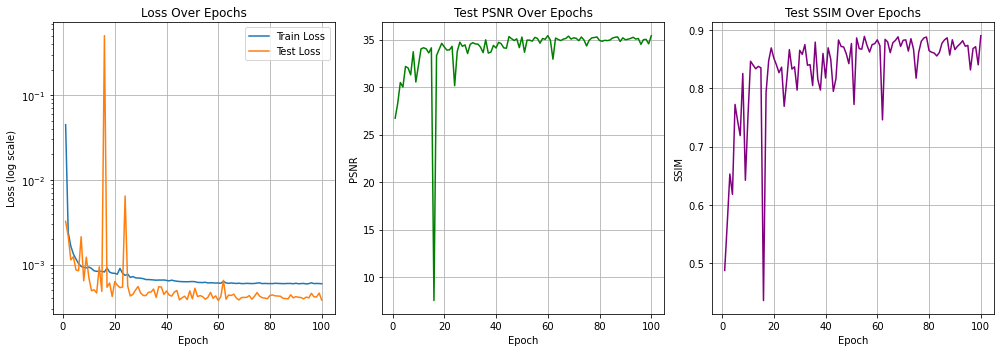

Metrics saved to: runs/run_20250401_100007/metrics.csv


In [13]:
EPOCHS = 100

run_dir = create_run_dir()
log_and_print = setup_logger(run_dir)

log_and_print("Starting new training run...")
log_and_print(f"Run directory: {run_dir}")

train_losses = []
test_losses = []
test_psnrs = []
test_ssims = []


for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        lr_imgs, hr_imgs = lr_imgs.cuda(), hr_imgs.cuda()

        optimizer.zero_grad()
        outputs = lr_imgs + model(lr_imgs)
        
        loss = criterion(outputs, hr_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    test_loss, test_psnr, test_ssim = evaluate_on_test_set(model, test_loader, criterion)

    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)
    test_psnrs.append(test_psnr)
    test_ssims.append(test_ssim)
  
    log_and_print(
        f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.8f} | "
        f"Test Loss = {test_loss:.8f} | PSNR = {test_psnr:.2f} | SSIM = {test_ssim:.4f}")

    if (epoch + 1) % 50 == 0:
        model_path = os.path.join(run_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        log_and_print(f"Saved model at epoch {epoch+1} to {model_path}")

    scheduler.step(test_loss)
    current_lr = optimizer.param_groups[0]['lr']
    log_and_print(f"Learning rate: {current_lr:.1e}")


log_and_export_metrics(train_losses, test_losses, test_psnrs, test_ssims, run_dir)

### Loading previously trained model

In [ ]:
model.load_state_dict(torch.load('3B_full_dataset.pth'))

### Checking the results

In [14]:
test_loss, test_psnr, test_ssim = evaluate_on_test_set(model, test_loader, criterion)
print(f"MSE = {test_loss:.8f} | PSNR = {test_psnr:.2f} | SSIM = {test_ssim:.4f}")

MSE = 0.00038109 | PSNR = 35.39 | SSIM = 0.8899


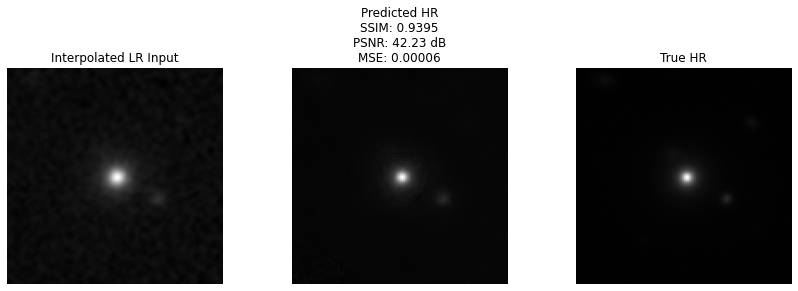

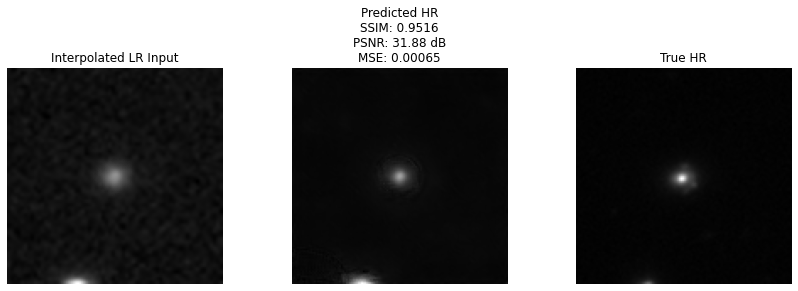

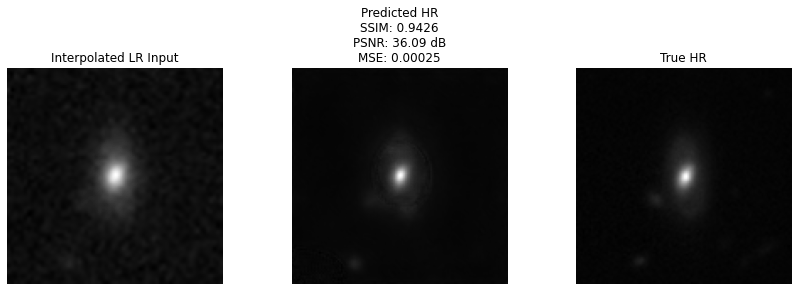

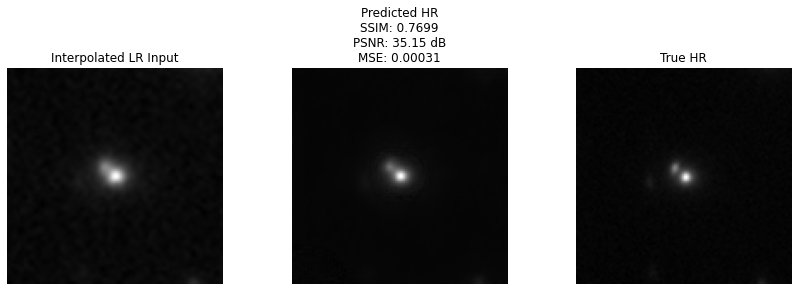

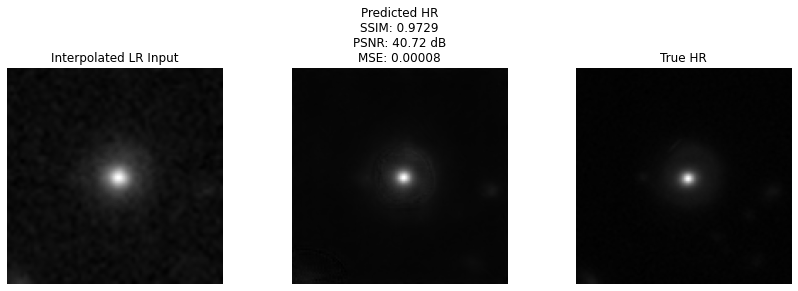

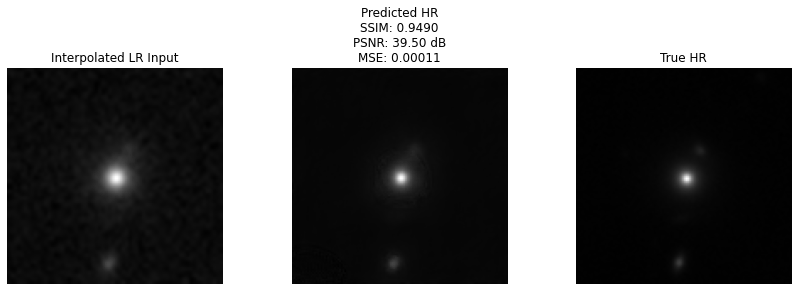

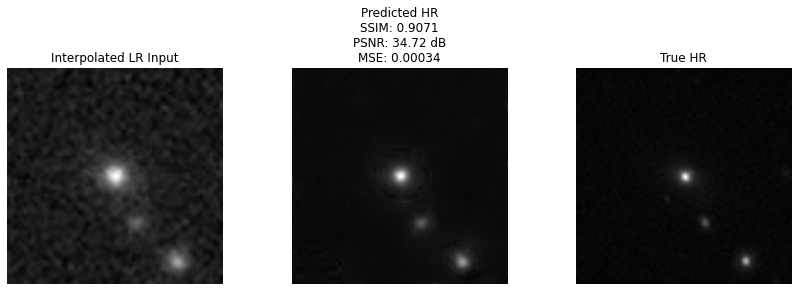

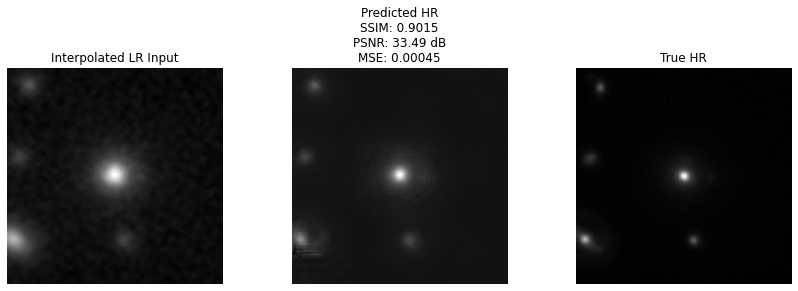

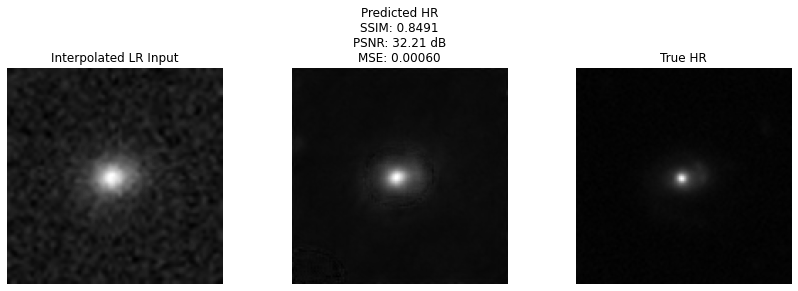

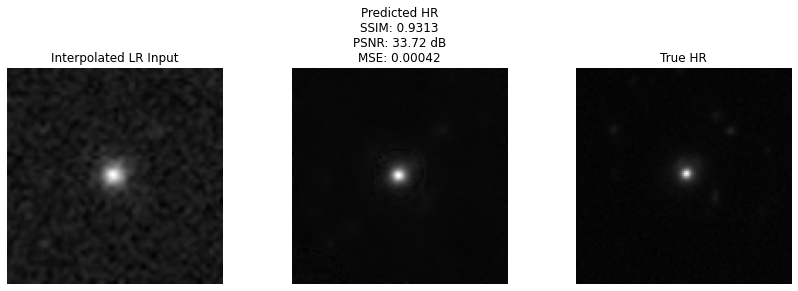

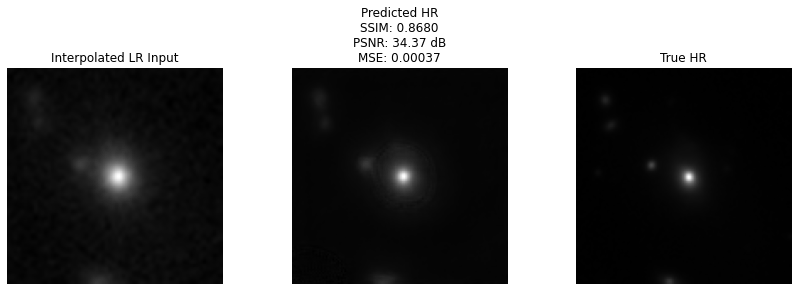

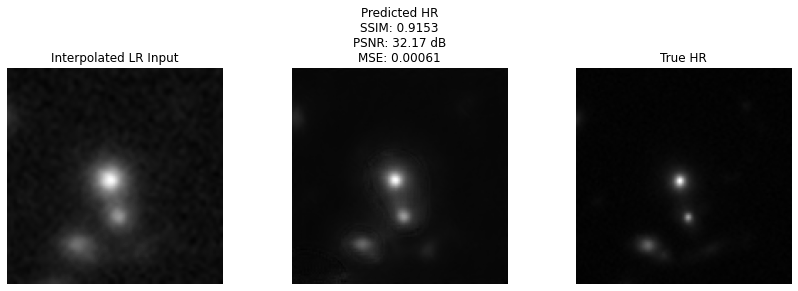

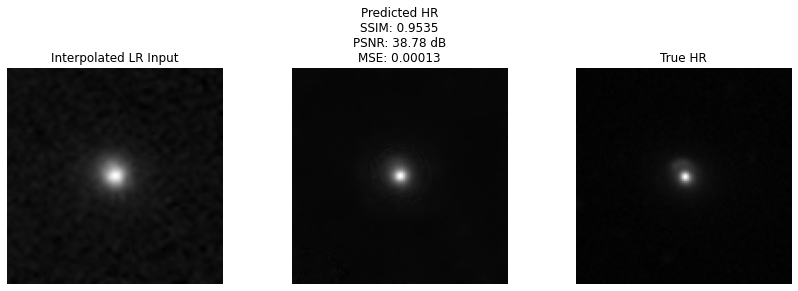

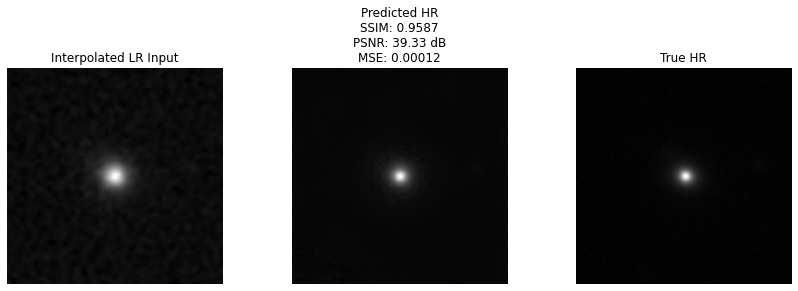

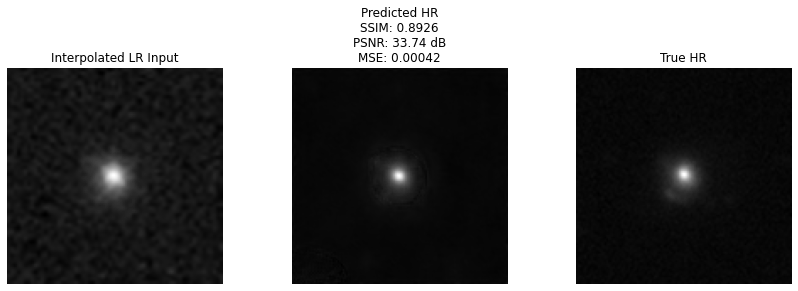

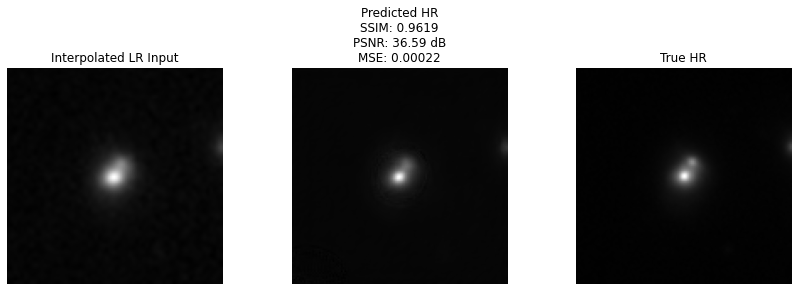

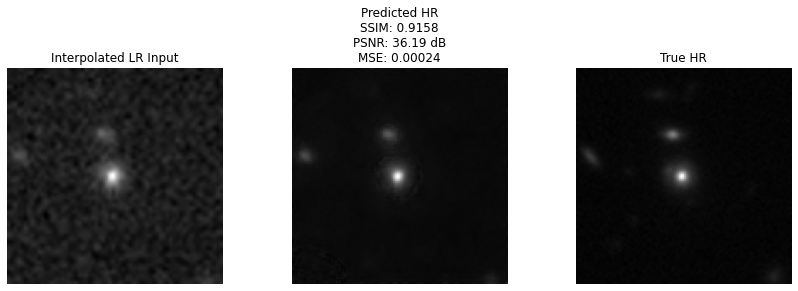

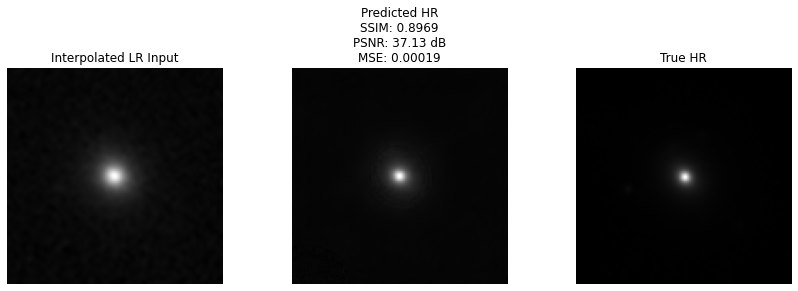

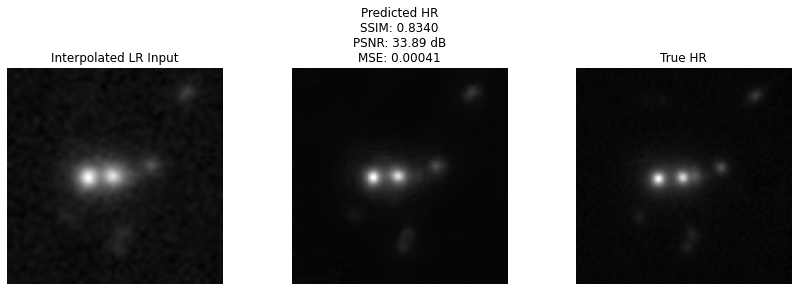

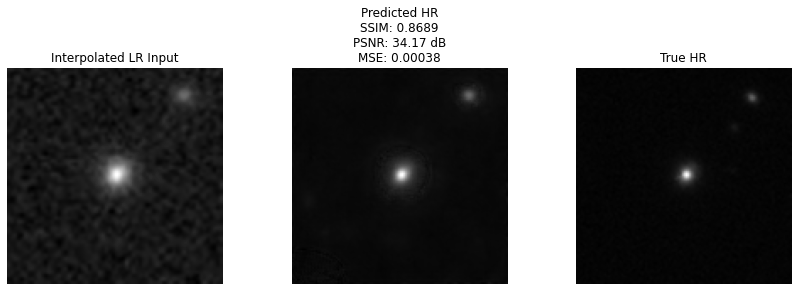

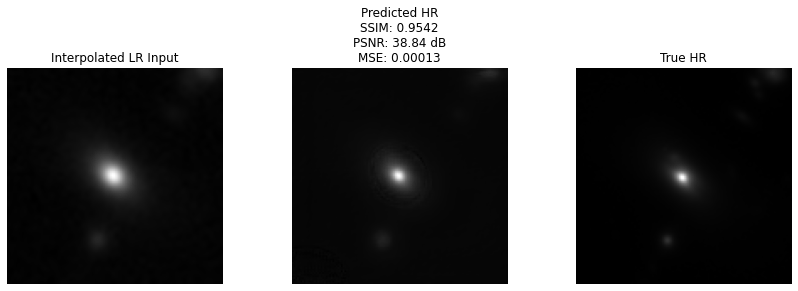

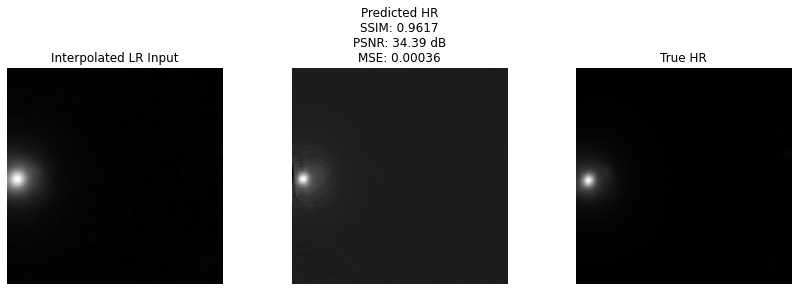

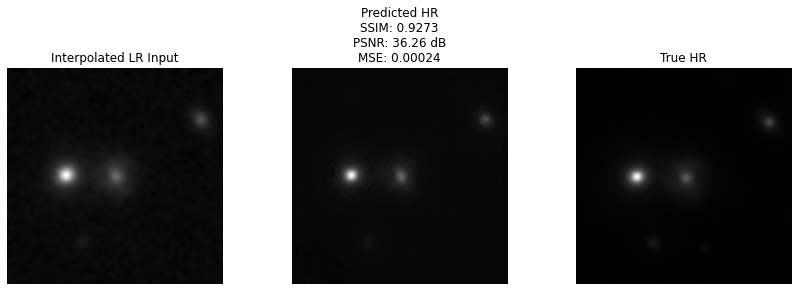

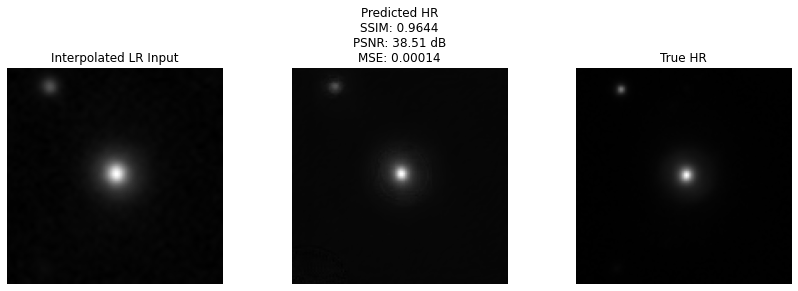

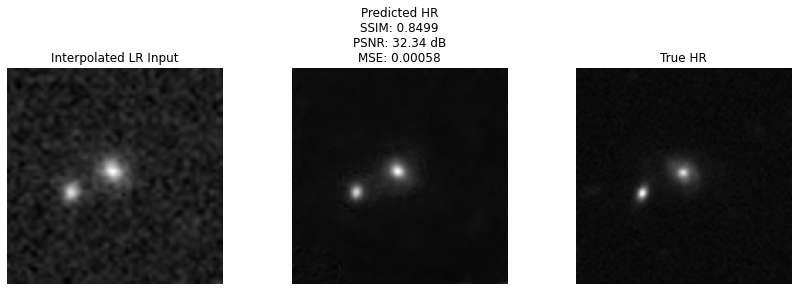

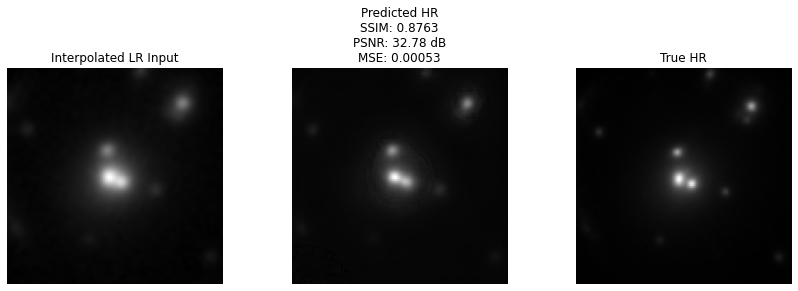

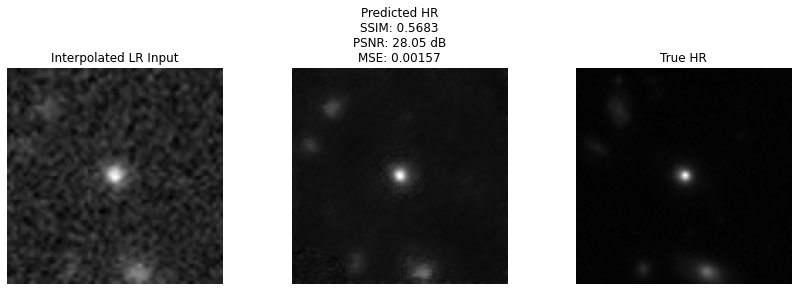

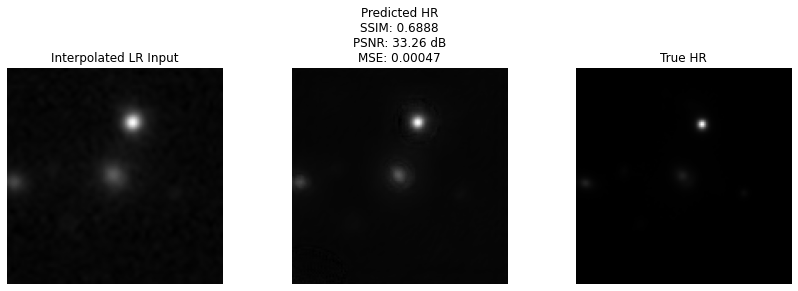

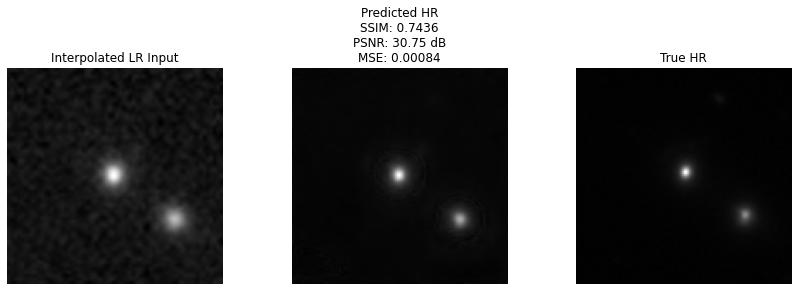

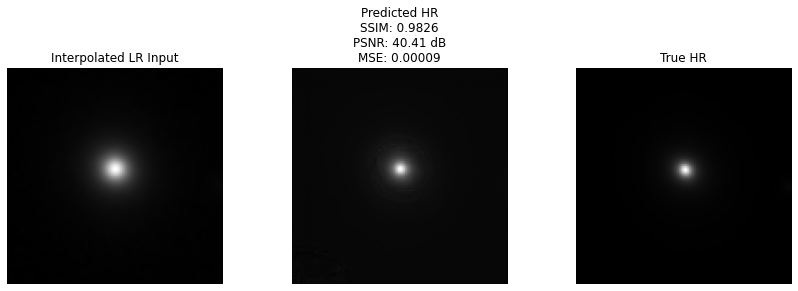

In [21]:
for i in range(len(test_set)):
    plot_super_resolution_sample(model, test_set, index=i, device='cuda')

### Further improvements
The dataset also has a bunch of LABELS which are not clearly corrupt, but still have noise in them. This reduces both the training quality and evaluation score. Following the same idea of dealing with a small dataset I manualy excluded these as well. After that the exact same model was trained on this reduced dataset (~80% of the original)

In [15]:
bad_and_noisy_indices = [11, 32, 191, 208, 12, 13, 18, 21, 26, 30, 46, 49, 50, 53, 55, 61, 67, 68, 69, 70, 86, 89, 90, 92, 96, 98, 107, 108, 119, 143, 146, 159, 166, 167, 168, 169, 177, 179, 183, 188, 189, 190, 196, 205, 206, 207, 215, 221, 227, 230, 231, 233, 241, 251, 257, 261, 269, 271, 279, 283, 287, 294, 296, 297]

In [16]:
bad_dataset = Subset(original_dataset, bad_and_noisy_indices)
bad_loader = DataLoader(bad_dataset, batch_size=1, shuffle=False)

good_indices = [i for i in range(len(original_dataset)) if i not in bad_and_noisy_indices]
clean_dataset = torch.utils.data.Subset(original_dataset, good_indices)

# show_dataset_grid(bad_dataset, num_rows = len(bad_and_noisy_indices))

In [17]:
model.load_state_dict(torch.load('3B_reduced_dataset.pth'))
test_loss, test_psnr, test_ssim = evaluate_on_test_set(model, test_loader, criterion)
print(f"MSE = {test_loss:.8f} | PSNR = {test_psnr:.2f} | SSIM = {test_ssim:.4f}")

MSE = 0.00031279 | PSNR = 36.25 | SSIM = 0.9013


### The performance of the model improved, though it is not obvious if this was fair since significant part of the dataset is now excluded. 
However this might imply that for the real task even with the small dataset it might worth reducing it even further and keep only the samples for which the labels are definetely high quality

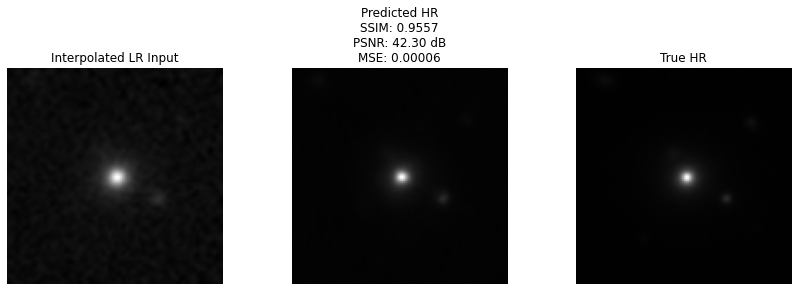

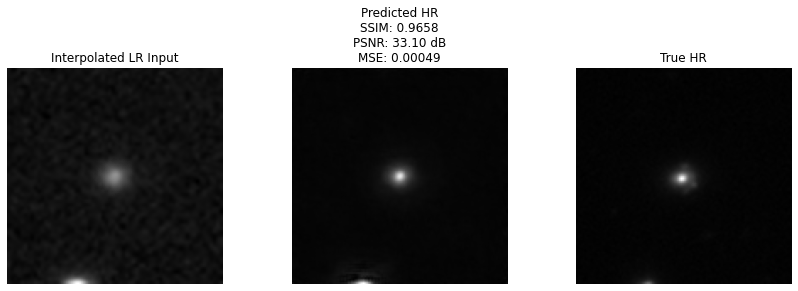

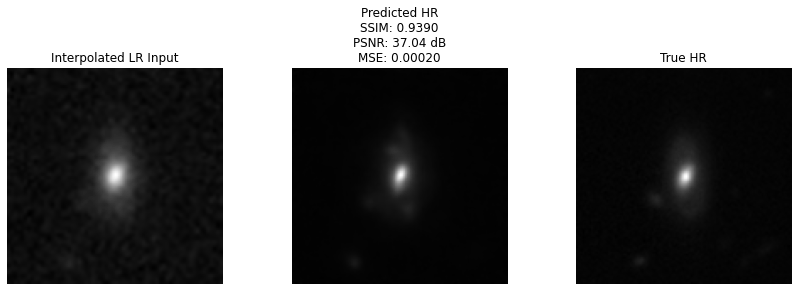

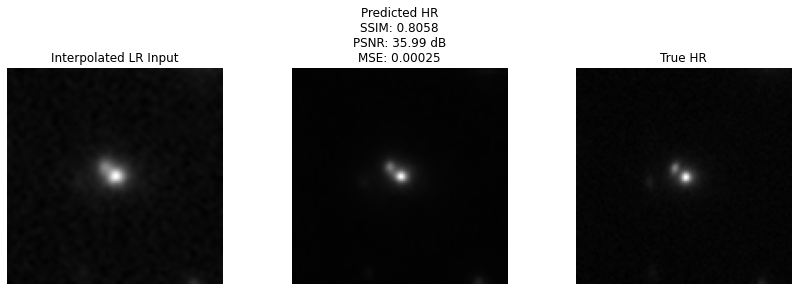

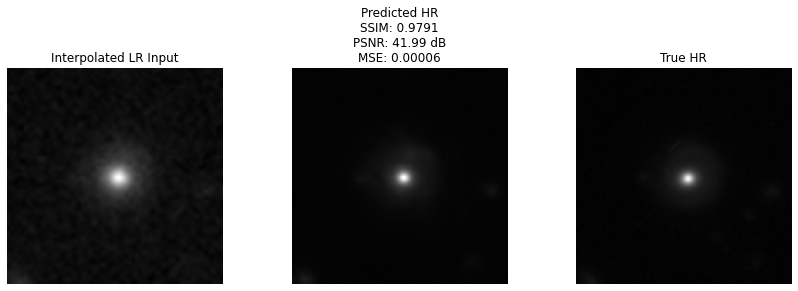

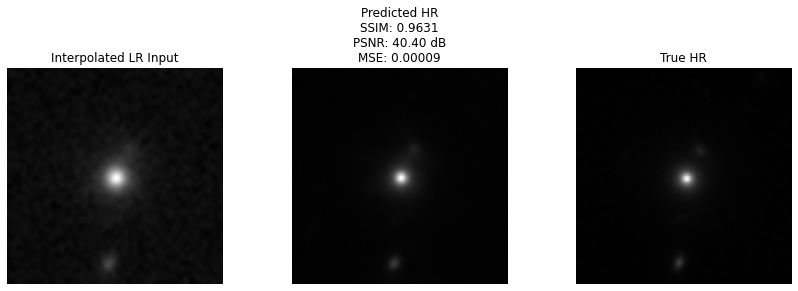

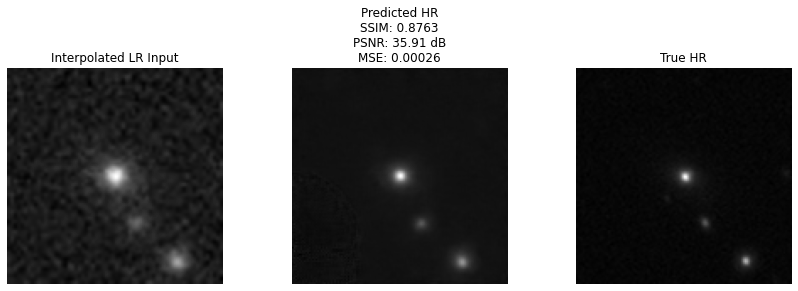

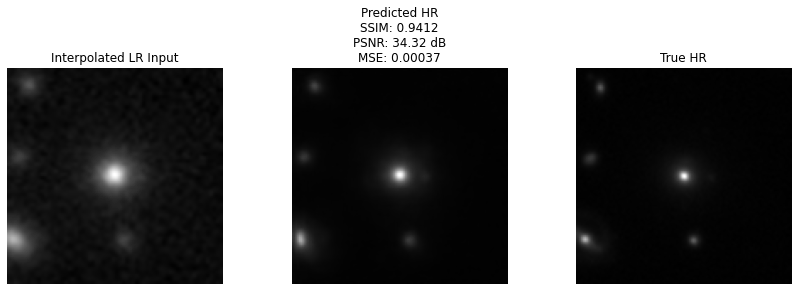

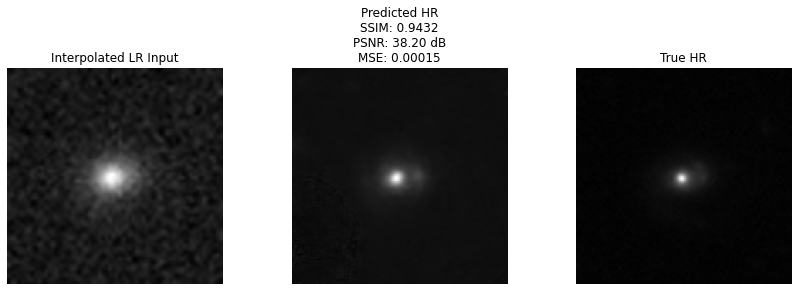

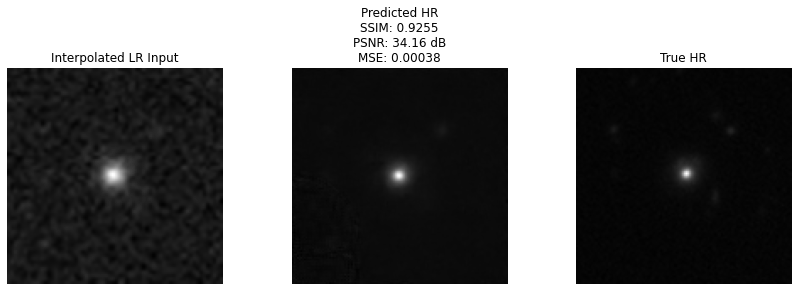

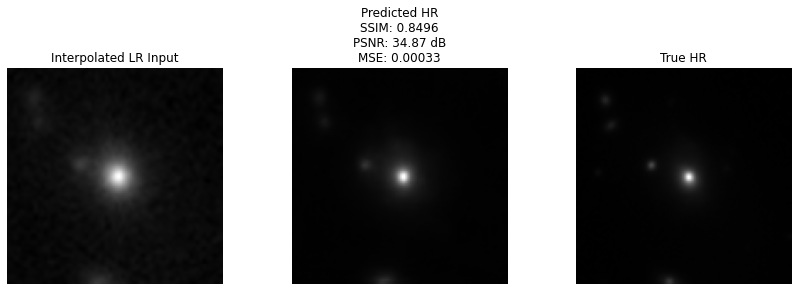

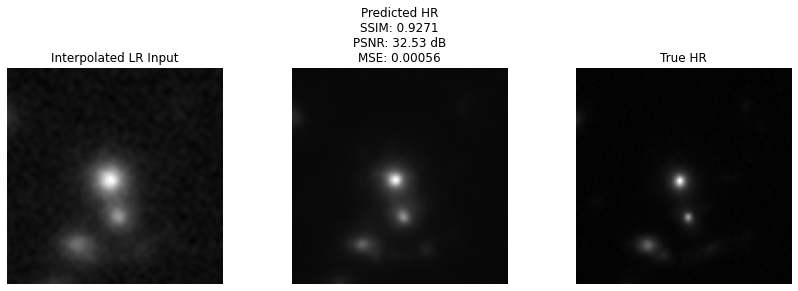

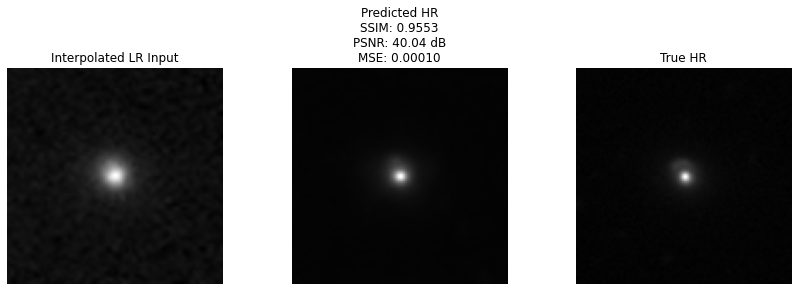

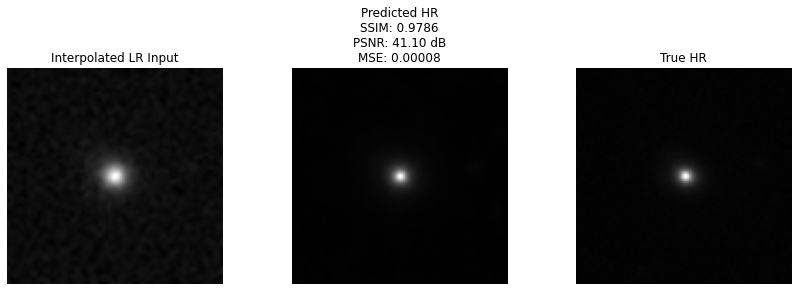

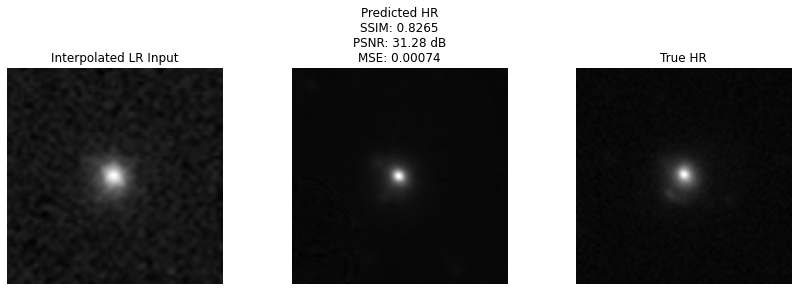

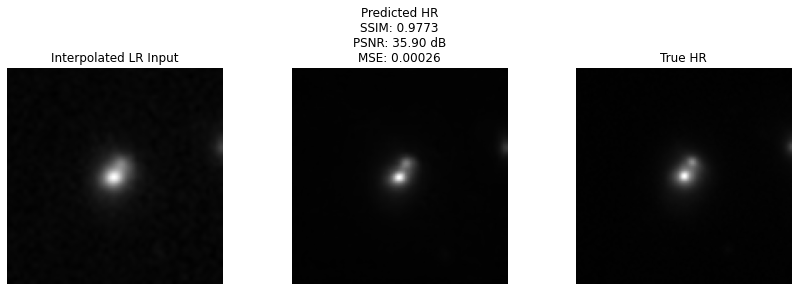

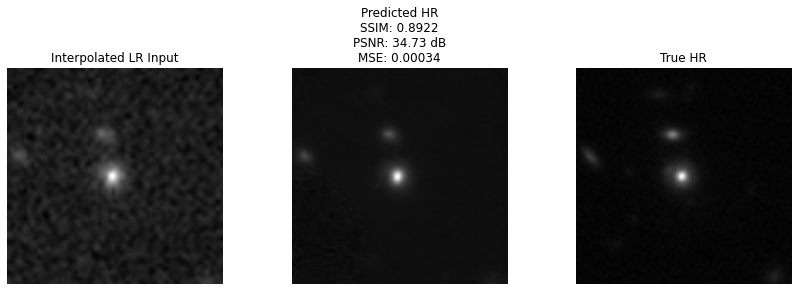

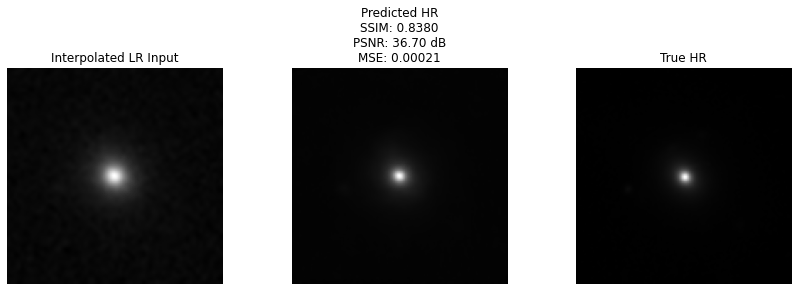

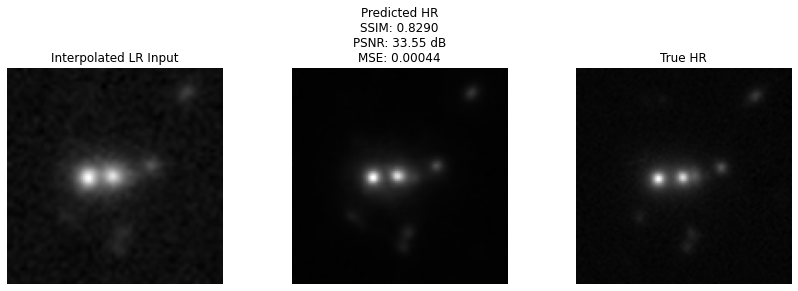

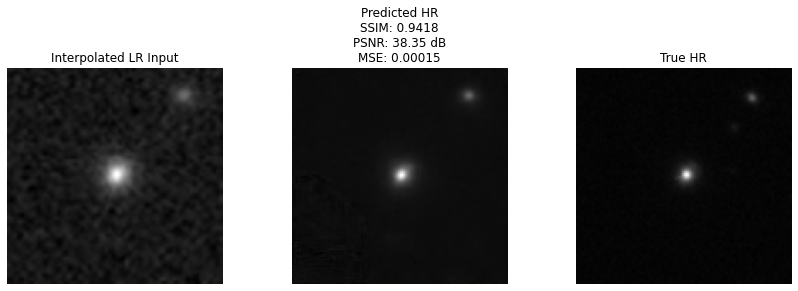

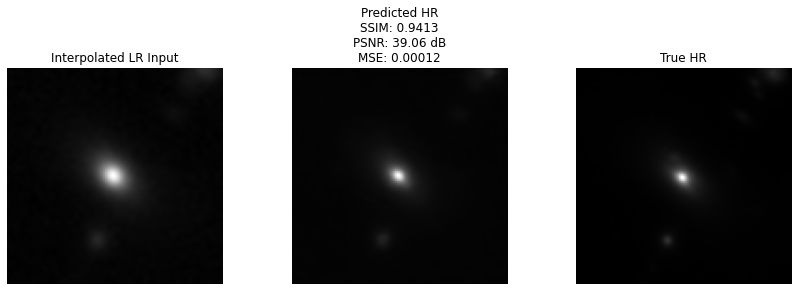

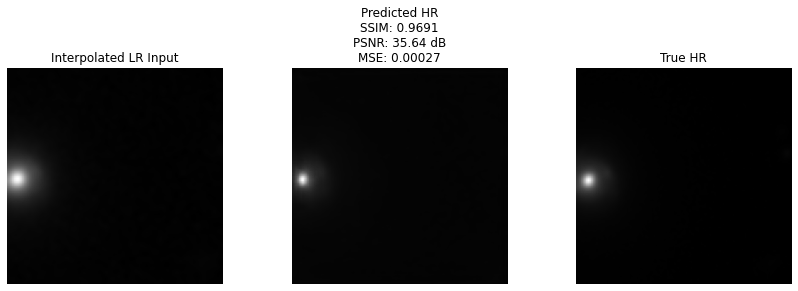

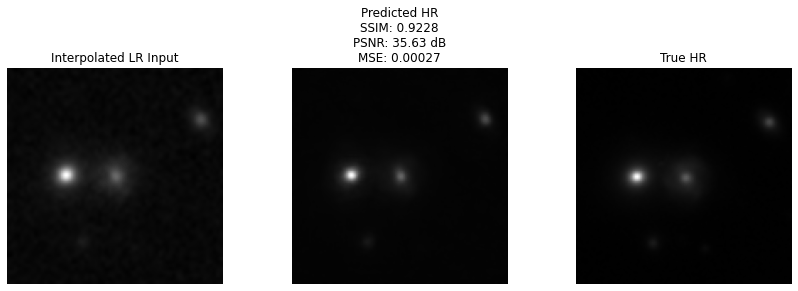

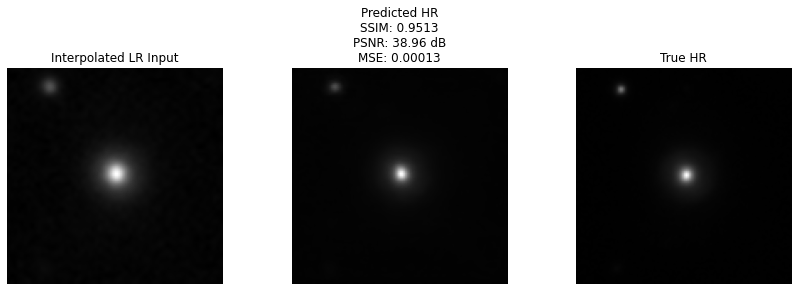

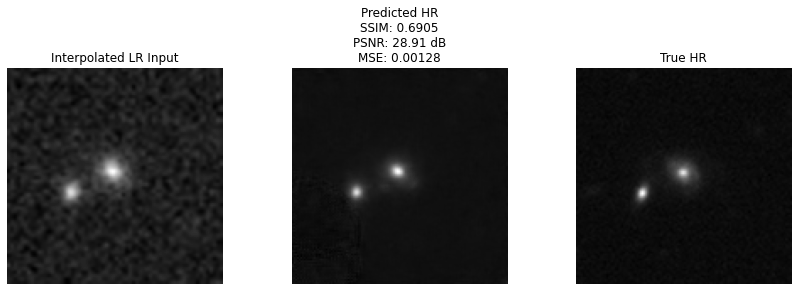

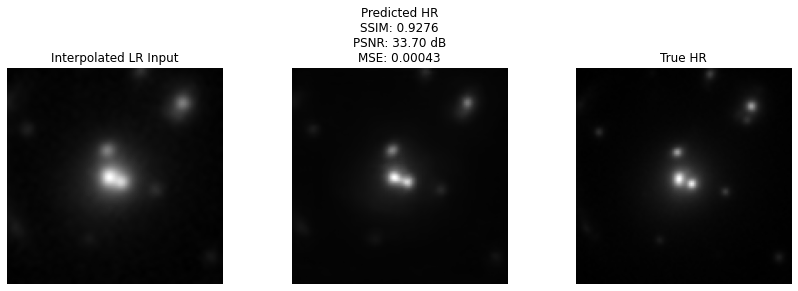

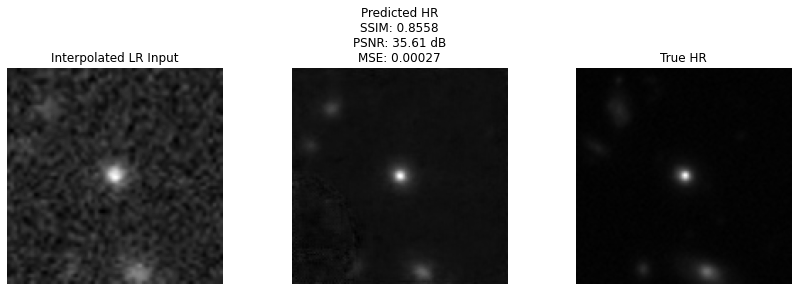

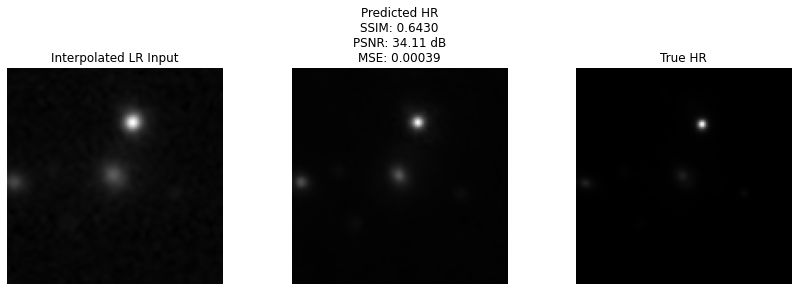

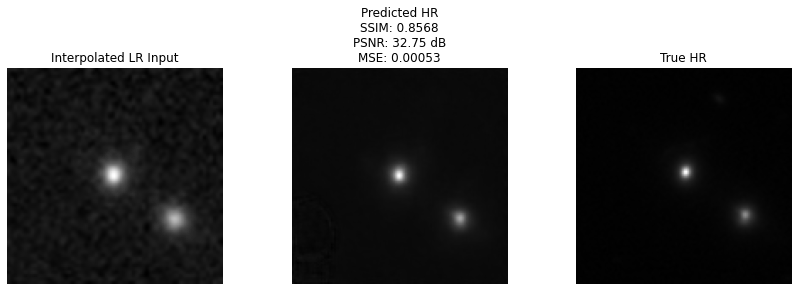

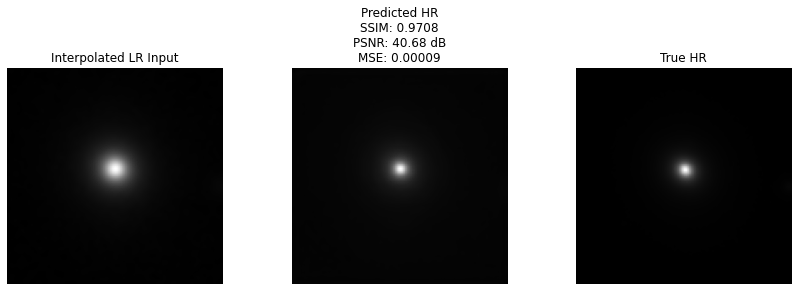

In [19]:
for i in range(len(test_set)):
    plot_super_resolution_sample(model, test_set, index=i, device='cuda')